<a href="https://colab.research.google.com/github/snoop2head/corona-virus-prediction/blob/master/corona19_confirmed_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

# Load Korean's confirmed cases dataset

In [0]:
# 존스홉킨스대학 CSSE github repository에서 데이터를 가져옵니다.
# Retreive data from Johns Hopkins University realtime COVID19 case upload
# https://github.com/CSSEGISandData/COVID-19

# Regional Confirmed cases dataframe across the world
# 전세계 지역 별 확진자 dataframe
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)

# Regional Deceases cases dataframe across the world
# 전세계 지역 별 사망자 dataframe
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
death = pd.read_csv(url, error_bad_lines=False)

# Regional Recovered cases dataframe across the world
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recover = pd.read_csv(url, error_bad_lines=False)

In [3]:
# Check the latest dataset's date
# 존스홉킨스 대학의 데이터셋은 매일 업데이트 됩니다. 방금 가져온 데이터의 날짜를 확인합니다. 
confirmed.columns[-1:]

Index(['3/2/20'], dtype='object')

In [4]:
# Make Korea's confirmed cases timeseries dataframe
# 한국의 확진자 시계열 데이터프레임를 확인합니다
df_korea = confirmed[confirmed['Country/Region'] == 'South Korea']
df_korea

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
33,NaN,South Korea,36.0,128.0,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,3736,4335


# Load other nation's confirmed cases (Example)

In [5]:
# United State and China's cases are divided into States or Provinces(省). 
# United State's Cases
df_US = confirmed[confirmed['Country/Region'] == 'US']
# df_US

# Following is example of dataframe for Los Angeles
df_LA = df_US[df_US["Province/State"] == "Los Angeles, CA"]
df_LA

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
48,"Los Angeles, CA",US,34.0522,-118.2437,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [6]:
# Rest of the regions are aggregation of nation's entire cases
# Following is example of dataframe of Italy's confirmed Cases
df_IT = confirmed[confirmed['Country/Region'] == 'Italy']
df_IT

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
60,NaN,Italy,43.0,12.0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036


# Make it Simple

In [7]:
# Exclude regional information from timeseries dataframe
# 한국 확진자 시계열 데이터프레임에서 위치 정보를 제외합니다. 
df_korea = df_korea.T[4:]

# Make Korean confirmed timeseries dataframe into two rows: date and number of confirmed cases
# 한국 확진자 시계열 데이터프레임을 두 개의 열로 만듭니다: 날짜, 확진자 수
df_korea = df_korea.reset_index().rename(columns={'index': 'date', 33: 'confirmed'})

df_korea['date'] = pd.to_datetime(df_korea['date'])

# Check the most recent 5 days of Korean confirmed cases 
# 한국 확진자 시계열 데이터프레임의 제일 최근 5일 간의 데이터를 확인합니다
df_korea.tail()

,date,confirmed
36,2020-02-27,1766
37,2020-02-28,2337
38,2020-02-29,3150
39,2020-03-01,3736
40,2020-03-02,4335


# Plot

In [8]:
# Plot Korean COVID19 confirmed cases 
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

fig

# Facebook Prophet

In [9]:
# Make dataframe for Facebook Prophet prediction model
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
36,2020-02-27,1766
37,2020-02-28,2337
38,2020-02-29,3150
39,2020-03-01,3736
40,2020-03-02,4335


# Create a Model

In [10]:
# Make Prophet model including daily seasonality
# Prophet에서 감안할 계절성을 선택해서 모델을 만듭니다
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [11]:
# Make future dataframe that will contain next 7 days of prediction 
# 다음 7일 동안의 시계열 데이터를 담기 위해서 데이터프레임을 제작합니다. 
future = m.make_future_dataframe(periods=7)

future.tail(7)

,ds
41,2020-03-03
42,2020-03-04
43,2020-03-05
44,2020-03-06
45,2020-03-07
46,2020-03-08
47,2020-03-09


# Predict

In [12]:
# predict future confirmed cases with prophet model
# prophet으로 만든 모델을 갖고 확진자 증가량을 예측해봅니다
forecast = m.predict(future)

# Meaning of y hat in linear regression can be referred in below
# 선형 회귀 분석에서 y hat이란? 
# https://www.statisticshowto.datasciencecentral.com/y-hat-definition/
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
41,2020-03-03,1743.095139,777.762318,2808.068171
42,2020-03-04,1802.554605,821.820252,2780.518960
43,2020-03-05,1862.014071,877.006654,2797.471733
44,2020-03-06,1921.473537,909.328569,2986.260185
45,2020-03-07,1980.933003,957.305737,2996.136593
46,2020-03-08,2040.392470,1090.447597,3123.526268
47,2020-03-09,2099.851936,1063.054990,3085.427988


# Plot Prediction

In [13]:
# Linear regression analysis is inappropriate prediction model for exponential increase of COVID19 confirmed cases
# 선형회귀 예측치(파란색 선)를 그래프로 표현해봅니다
# 확진자들의 지수적인 증가를 담아내지 못함을 알 수 있습니다.
fig = plot_plotly(m, forecast)
py.iplot(fig)

# Add changepoints to Make More Flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [14]:
# Make New Model with changepoints: divide into severel linear regressions to capture exponential increase
# 보다 정확한 결과를 얻기 위해서, changepoint를 반영해서 새로 모델링을 합니다
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible
    changepoint_range=0.98, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)


m.fit(df_prophet)

In [15]:
# Display new model's forecast of Korean COVID19 confirmed cases into table
# 다음 일주일 간의 예상 확진자 수를 표로 나타내봅니다.
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
forecast.tail(7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
41,2020-03-03,5001.494664,4961.295547,5037.227599,4985.460669,5010.748174,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,0.0,0.0,0.0,4999.410025
42,2020-03-04,5637.346173,5569.019932,5686.353514,5582.914356,5683.812616,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,0.0,0.0,0.0,5635.261535
43,2020-03-05,6273.197683,6164.171634,6368.159730,6162.711929,6368.038761,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,0.0,0.0,0.0,6271.113044
44,2020-03-06,6909.049192,6737.384825,7079.510358,6749.095056,7072.353443,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,0.0,0.0,0.0,6906.964553
45,2020-03-07,7544.900702,7314.883923,7775.751994,7323.794832,7774.683112,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,0.0,0.0,0.0,7542.816063
46,2020-03-08,8180.752211,7866.223963,8484.679467,7872.827861,8480.462678,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,0.0,0.0,0.0,8178.667572
47,2020-03-09,8816.603721,8417.921878,9200.221765,8417.526075,9197.913002,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,-2.084639,0.0,0.0,0.0,8814.519082


In [16]:
# Plot new model's expected confirmed cases
# Change Point를 넣어서 모델링한 예상 확진자 수를 그래프로 그려봅시다
fig = plot_plotly(m, forecast)
py.iplot(fig)

# Plot changepoints

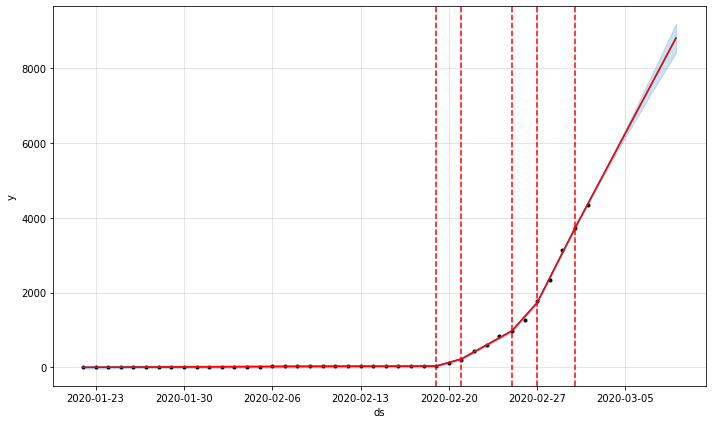

In [17]:
# display changepoints as red dotted line on the plot
# changepoint를 그래프에 반영해봅시다
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)